In [151]:
# Packages
import pandas as pd 
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import recall_score,auc
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn import preprocessing 
from sklearn import metrics
import seaborn as sns
import random
import warnings 
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Grain setting guarantees the reproductibility of results
np.random.seed(123) 

# Loading data
data = pd.read_csv('german_credit_data_dataset.csv')

Data preperation
====

In [166]:
data.head()
data.customer_type=data.customer_type-1


In [167]:
# Spliting data in to test and train set 

X_train, X_test, Y_train, Y_test = train_test_split(data.drop('customer_type', axis=1), data['customer_type'])

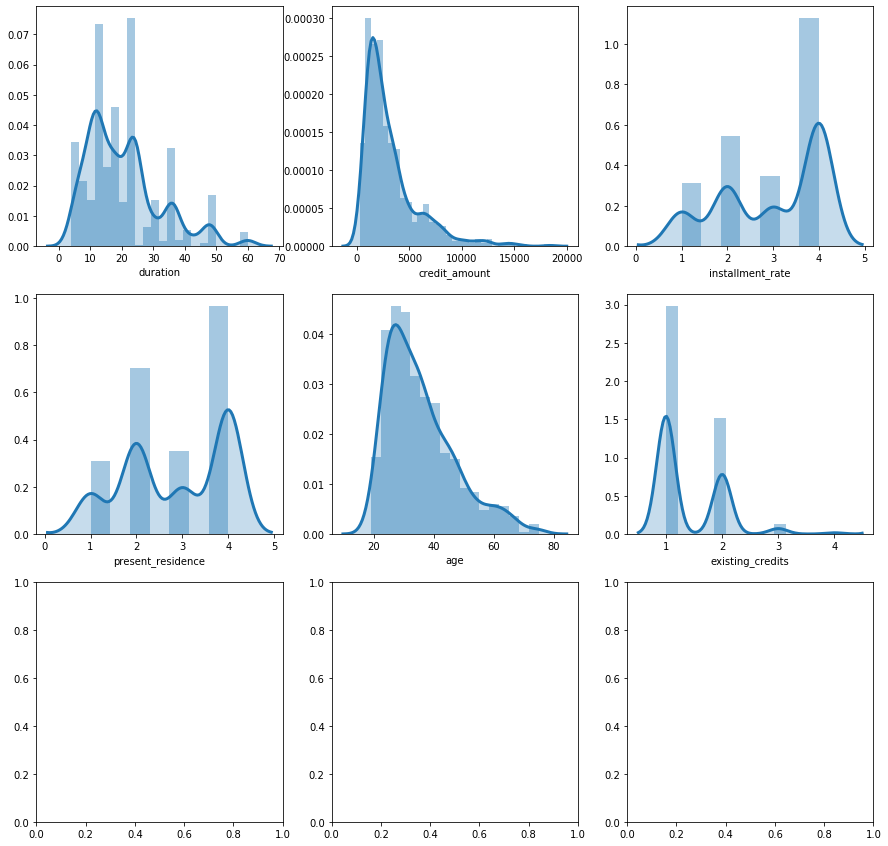

In [169]:
# column with numeric data
num_cols = X_train.columns[X_train.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

# numeric feature distribution 
f, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(6):
    plot_dens=sns.distplot(X_train[num_cols].iloc[:,i], hist = True, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, ax=axs[ i//3 ,i%3])

In [170]:
# transforming numerical comuns  
from sklearn.preprocessing import PowerTransformer


tr = PowerTransformer(method='box-cox',copy=False,standardize=False)
X_train[num_cols] = tr.fit_transform(X_train[num_cols])
X_test[num_cols] = tr.transform(X_test[num_cols])

In [196]:
# target encoding for kategorical values
import category_encoders as ce 

cols = data.select_dtypes(include = 'object').columns.values 



target = ce.TargetEncoder(data,cols=cols)


X_train = target.fit_transform(X_train,Y_train)
X_test=target.transform(X_test)

########## DANE DO TESTU 
X_train.to_csv("dane_test")

#########  DANE DO TESTU 


Feature importance
====

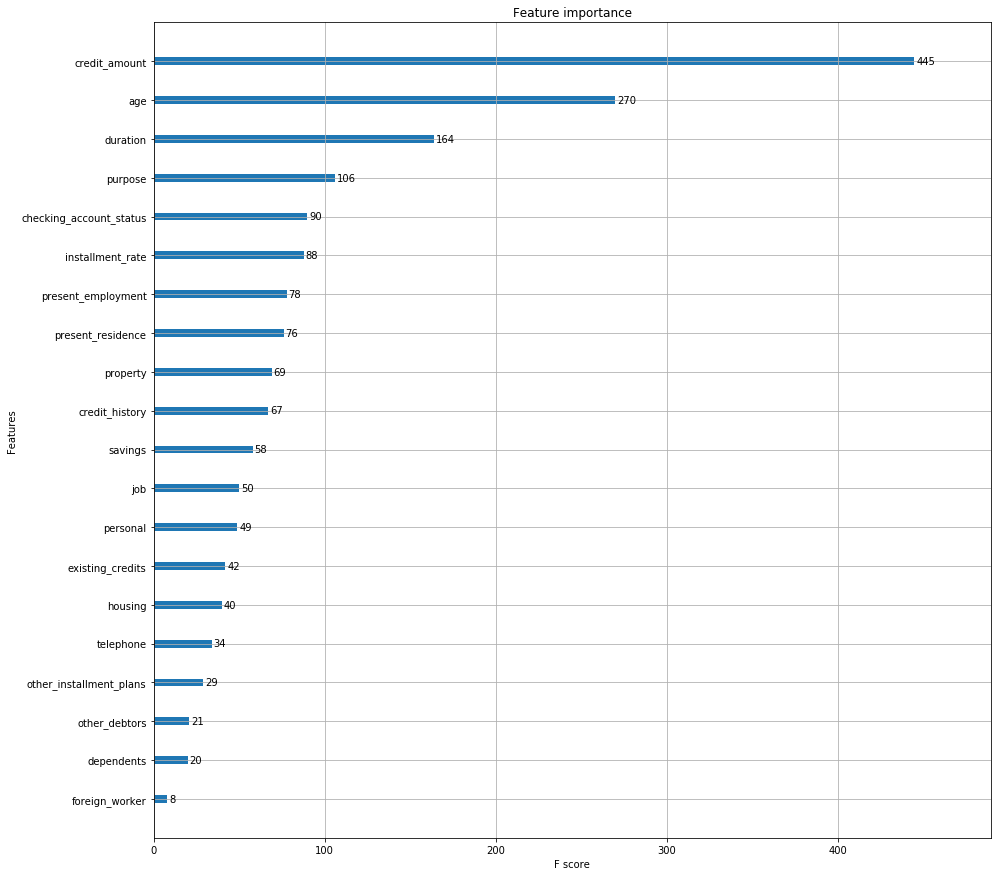

In [182]:
# polt 
import xgboost as xgb
xgb_= xgb.XGBClassifier(objective = 'binary:logistic')
xgb_.fit(X_train,Y_train)



from xgboost import plot_importance
from matplotlib import pyplot
plt.rcParams['figure.figsize'] = [15, 15]
plot_importance(xgb_)

pyplot.show()

Best feature is Credit ammount but most important features is numeric features what can be interesting.

In [185]:
# SelectKBest for xgb 


from sklearn.feature_selection import SelectKBest


pipline_kbest = Pipeline([('select',SelectKBest()),('model',xgb.XGBClassifier(objective = 'binary:logistic'))])

param_grid = {'select__k':[i for i in range(20)]}

grid_search = GridSearchCV(pipline_kbest,param_grid=param_grid,cv=5,n_jobs=-1).fit(X_train,Y_train)


In [190]:
print(grid_search.best_params_)
# see 18 best features
selector=SelectKBest(k=16)

selector.fit(X_train,Y_train)
score= selector.scores_
import heapq


Kbest_index=heapq.nlargest(16, range(len(score)), score.take)
X_train_kbest=X_train.iloc[:,Kbest_index]
X_test_kbest=X_test.iloc[:,Kbest_index]

X_train.columns[Kbest_index]
_

{'select__k': 18}


BorutaPy(alpha=0.05,
         estimator=XGBClassifier(base_score=0.5, booster=None,
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=1, gamma=0, gpu_id=-1,
                                 importance_type='gain',
                                 interaction_constraints=None,
                                 learning_rate=0.300000012, max_delta_step=0,
                                 max_depth=6, min_child_weight=1, missing=nan,
                                 monotone_constraints=None, n_estimators=62,
                                 n_jobs=0, num_parallel_tree=1,
                                 objective='binary:logistic',
                                 random_state=2077805916, reg_alpha=0,
                                 reg_lambda=1, scale_pos_weight=1, subsample=1,
                                 tree_method=None, validate_parameters=False,
                                 verbosity=None),
         m

In [191]:
# Boruta algoritm 
from boruta import BorutaPy

feat_selector = BorutaPy(xgb_, n_estimators='auto')
feat_selector.fit(X_train.values,Y_train)


BorutaPy(alpha=0.05,
         estimator=XGBClassifier(base_score=0.5, booster=None,
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=1, gamma=0, gpu_id=-1,
                                 importance_type='gain',
                                 interaction_constraints=None,
                                 learning_rate=0.300000012, max_delta_step=0,
                                 max_depth=6, min_child_weight=1, missing=nan,
                                 monotone_constraints=None, n_estimators=62,
                                 n_jobs=0, num_parallel_tree=1,
                                 objective='binary:logistic',
                                 random_state=987866629, reg_alpha=0,
                                 reg_lambda=1, scale_pos_weight=1, subsample=1,
                                 tree_method=None, validate_parameters=False,
                                 verbosity=None),
         ma

In [193]:
# feature ranking
a=feat_selector.support_
ranking=feat_selector.ranking_

# chceking evry posible tresholde

for i in range(1,15):
    xgb_test = xgb.XGBClassifier(objective='binary:logistic')
    data_test = ranking>=i
    xgb_test.fit(X_train.iloc[:,data_test],Y_train)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, xgb_test.predict(X_test.iloc[:,data_test]))
    print(i,metrics.auc(fpr,tpr))
    
# results worst then with k best feature 

1 0.6872353297035694
2 0.6194041137326073
3 0.5910465819721719
4 0.565562613430127
5 0.5832577132486388
6 0.5618572292800967
7 0.5618572292800967
8 0.5503629764065335
9 0.551194797338173
10 0.5104355716878403
11 0.5104355716878403
12 0.4944041137326074
13 0.4944041137326074
14 0.5045372050816697


In [197]:
# Selected featrues vs all features

xgb1 = xgb.XGBClassifier(objective = 'binary:logistic')
xgb2 = xgb.XGBClassifier(objective = 'binary:logistic')

xgb1.fit(X_train,Y_train)
xgb2.fit(X_train_kbest,Y_train)

pre1 = xgb1.predict(X_test)
pre2 = xgb2.predict(X_test_kbest)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, pre1)
print(f'Auc for selected features : {metrics.auc(fpr,tpr)}')


fpr, tpr, thresholds = metrics.roc_curve(Y_test, pre2)
print(f'Auc for all features : {metrics.auc(fpr,tpr)}')

# Better auc for all  feturs

Auc for selected features : 0.6872353297035694
Auc for all features : 0.6966878402903812
